# Person - EDA and Forecasting

This Notebook is the basis for forecasting object counts given a date and hour. It contains 3 sections:

- **Data preparation**. Here we will compose the dataset and describe the features.
- **Data exploration**. In this section we will start reviewing individual features.
- **Predicting object counts**. Here we will focus on generating an hourly forecast for a given day based on the selected attributes. The aim is to find the most useful model for this task.

In [254]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

TF -> Using GPU ->  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Data preparation

The raw data extracted from the images is at the object level. Here are a few sample observations:

In [256]:
df = pd.read_csv('../Datasets/UniqueObjectDetections__person__2019-09-09_2020-03-02.csv')
print(df.shape)
df.head(2)

(4790, 26)


,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min,dummy_var,time_diff,sec_diff,x_center,y_center,prev_x_center,prev_y_center,euc_distance
0,73740,person,0.450496,459,24,478,38,2019-09-09,07.03.03,07.03.03.965_4d9909b4_person-car-car-car.jpg,2,965,2019-09-09 07:03:03.965,Monday,False,9,7,3,1,0 days 00:42:40.471000000,2560.471,468.5,31.0,490.0,310.0,279.827179
1,73135,person,0.658724,286,238,381,340,2019-09-09,07.29.50,07.29.50.440_4e0ee29d_person-car-car.jpg,1,440,2019-09-09 07:29:50.440,Monday,False,9,7,29,1,0 days 00:26:46.475000000,1606.475,333.5,289.0,468.5,31.0,291.185508


Analysis below will be performed at the daily / hourly level.

I have tried several other approaches (from 15-minute to 3-hour time intervals), but 15 minute intervals are definitely too random and 3 hours reduces the dataset size dramatically. Based on that it seems like hourly analysis (and later forecasting) is a good trade off.

To roll up the data to daily / hourly level we can use Pandas. This is straight forward.

The only issue I have identified with this approach is that it will only include date / hour combinations with observations. But in order to analyse data, gaps without any observations need to be filled with 0's. This is done in the `resampling` code snippet below.

In [257]:
# make sure Pandas understands date time fields
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = pd.to_datetime(df['date'])

# use Pandas handy resample feature to fill in gaps with 0's
object_detections = df.set_index('date_time').resample('H')['dummy_var'].sum().reset_index()
object_detections.columns = ['date_time', 'obs_count']
object_detections['date'] = object_detections['date_time'].dt.date.astype(str)
object_detections['hour'] = object_detections['date_time'].dt.hour
object_detections = object_detections[['date', 'hour', 'obs_count']]
object_detections.head(2)

,date,hour,obs_count
0,2019-09-09,7,2
1,2019-09-09,8,3


Now we will strip the dates with the server or power outage

In [258]:
# remove any entries where we know that there was an error in measurements
orig_size = object_detections.shape[0]
idx = object_detections['date'].isin(['2020-01-13', '2020-01-14', '2020-02-28'])
object_detections = object_detections.loc[~idx]
print(f'Removed {orig_size - object_detections.shape[0]} records')

Removed 72 records


Now we can add some useful features based on the date column:

In [259]:
# add date-time related features
object_detections['date'] = pd.to_datetime(object_detections['date'])
object_detections['n_month'] = object_detections['date'].dt.month
object_detections['n_week_in_month'] = (object_detections['date'].dt.day-1)//7+1
object_detections['day_of_week'] = object_detections['date'].dt.dayofweek
object_detections['day_of_week_name'] = object_detections['date'].dt.day_name()
object_detections['is_weekend_day'] = ((object_detections['date'].dt.dayofweek) // 5 == 1).astype(int)
object_detections['day_of_week_name_short'] = 'WeekDay'
idx = object_detections['day_of_week_name'].isin(['Saturday', 'Sunday'])
object_detections.loc[idx, 'day_of_week_name_short'] = object_detections[idx]['day_of_week_name']
object_detections.head(2)

,date,hour,obs_count,n_month,n_week_in_month,day_of_week,day_of_week_name,is_weekend_day,day_of_week_name_short
0,2019-09-09,7,2,9,2,0,Monday,0,WeekDay
1,2019-09-09,8,3,9,2,0,Monday,0,WeekDay


Next, we can load the Dark Sky weather data extracted from Dark Sky API in the other Notebook.

The idea here is that features from this dataset might be useful to predict the count of observations in a given hour.

#### Warning!

We are bringing-in here the actual weather data.

We need to be careful here, as when system runs in *Production*, it will use the weather forecast (not actuals), which can be wrong.

This variability can be costly and needs special attention down the line.

In [56]:
# load weather data
weather = pd.read_csv('../Datasets/dark_sky_data_2019-09-09_2020-03-02.csv')
weather.head(2)

,ts,dt,cur__summary,cur__precipIntensity,cur__precipProbability,cur__precipType,cur__temperature,cur__apparentTemperature,cur__humidity,cur__windSpeed,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__summary,daily__sunriseTime,daily__sunsetTime,daily__temperatureHigh,daily__temperatureLow
0,1567985400,2019-09-09 00:30:00,Possible Light Rain,0.7929,0.47,rain,14.06,14.08,0.96,21.30,35.13,241,0.99,0,10.796,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01
1,1567989000,2019-09-09 01:30:00,Possible Light Rain,0.8310,0.45,rain,13.99,13.99,0.93,22.49,35.87,215,0.96,0,10.945,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01


Next, we can extend the weather data slightly and a few more date/time related features, which will allow us to join the 2 dataframes together in the next step.

In [57]:
# add date-time related features, so we can merge the datasets together
weather['dt'] = pd.to_datetime(weather['dt'])
weather['date'] = weather['dt'].dt.date
weather['date'] = pd.to_datetime(weather['date'])
weather['hour'] = weather['dt'].dt.hour
check_cols = ['dt', 'date', 'hour']
weather[check_cols].head(2)

,dt,date,hour
0,2019-09-09 00:30:00,2019-09-09,0
1,2019-09-09 01:30:00,2019-09-09,1


Now we can merge the 2 data sources and verify that all none of the observations was dropped

In [58]:
# join detections and weather data
merged = object_detections.merge(weather, on=['date', 'hour'])

# make sure that we have not lost any observations
assert object_detections.shape[0] == merged.shape[0]

## Data exploration

Here we will the current shape of the data, all features along with their data types and we will verify if we have any missing data to deal with.

In [59]:
print(f'We have {merged.shape[0]} records with {merged.shape[1]} features')

We have 4140 records with 29 features


In [60]:
nulls = merged.isnull().sum().reset_index()
null_count = nulls[nulls[0] > 0].shape[0]
print (f'We have {null_count} missing values')

We have 0 missing values


Based on the information above, we don't have any missing data. This is good as dealing with missing data is always troublesome and both: removing the rows and imputing the values are never a perfect solution.

In [61]:
# print data types for each of the columns
# print(merged.dtypes)

To keep this Notebook clean I am not printing a summary for the datatypes of all the features, but here is the summary:
- 2 date/time columns
- 5 character-based columns
- 11 integer columns
- 11 floating point columns

Now lets plot the histograms for the selected numerical features and explore their distributions

In [62]:
# select features to inspect
inspect_cols = [
    ['cur__precipIntensity', 'cur__precipProbability', 'cur__temperature', 'cur__apparentTemperature'],
    ['cur__humidity', 'cur__windSpeed', 'cur__windGust', 'cur__windBearing'],
    ['cur__cloudCover', 'cur__uvIndex', 'cur__visibility', 'daily__temperatureHigh']
]
inspect_cols_flat = np.array(inspect_cols).flatten().tolist()

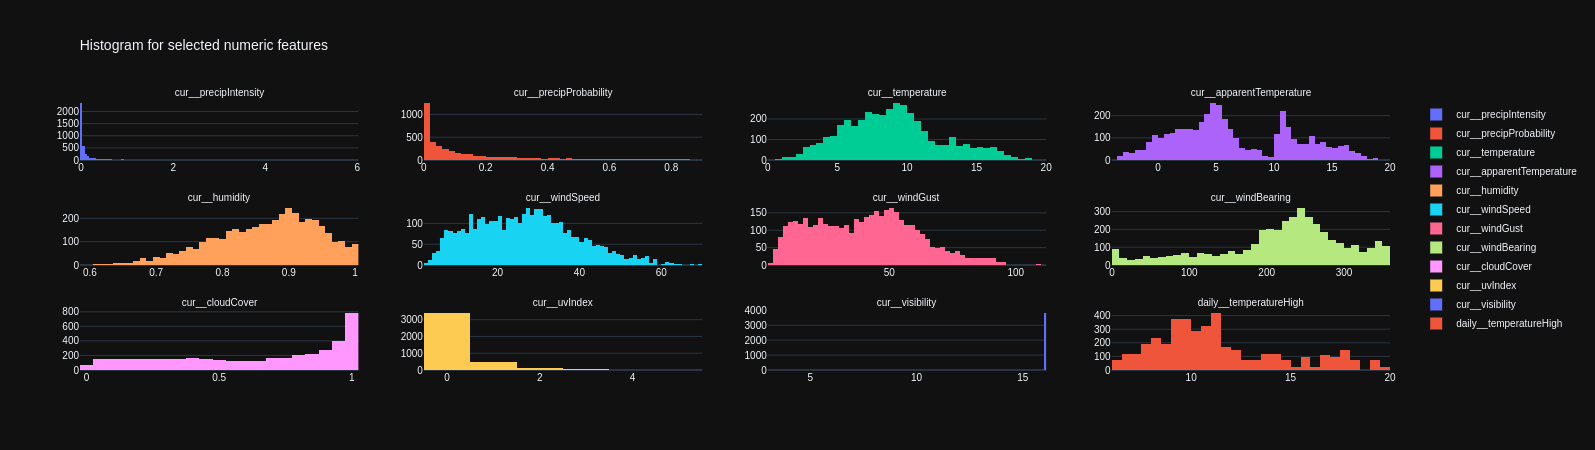

In [63]:
# draw a subplot with a histogram for each feature
from plotly.subplots import make_subplots

fig = make_subplots(rows=len(inspect_cols), cols=len(inspect_cols[0]),
                    subplot_titles=tuple(inspect_cols_flat))
for i, col_set in enumerate(inspect_cols):
    for j, c in enumerate(col_set):
        fig.add_trace(go.Histogram(x=merged[c], name=c), row=i+1, col=j+1)
fig.update_layout(height=550, title_text="Histogram for selected numeric features", font=dict(size=10))
for i in fig['layout']['annotations']: i['font'] = dict(size=10)  # change subplot titles size
fig.show()

As we can see, the distibutions vary a lot.

We have some nice almost Gaussian distribution for the `temperature`, `humidity` and `wind`, and we have other distibutions, which follow a very different trends, like `precipitation`, `cloud-cover`, `uv-index` and `visibility`.

If we wanted to use a Linear Model to predict the counts from these features, it would not be able to use more than half of them and we would need to transform the data using one of the known methods:
- square root
- natural logarithm
- reciprocal transformation

Since I will be using a more complex/not linear model below, I will not be transforming the data at all and even when transformations were applied, they did not improve the accuracy of prediction models.

#### TODO: Deal with some features containing outliers:
- somehow impute (min, max, mean, median or cap at value) or remove records

## Target variable

What about the values, which we are trying to predict?

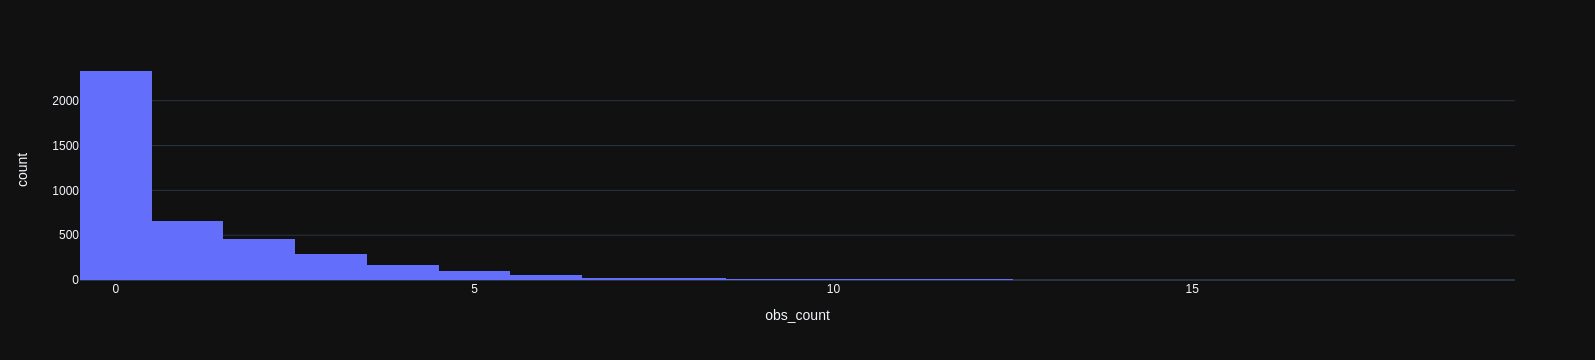

In [64]:
px.histogram(merged, x='obs_count', nbins=int(merged['obs_count'].max()) + 1,
             height=250, width=650)

The plot above seems to indicate that the data is skewed toward zero's.

The dataset has a lot of variability, as the same plot will look definitely different for 1AM and for 1PM. The nightly hours will be dominated by zeros, while during the day we will usually see 1 or 2 objects:

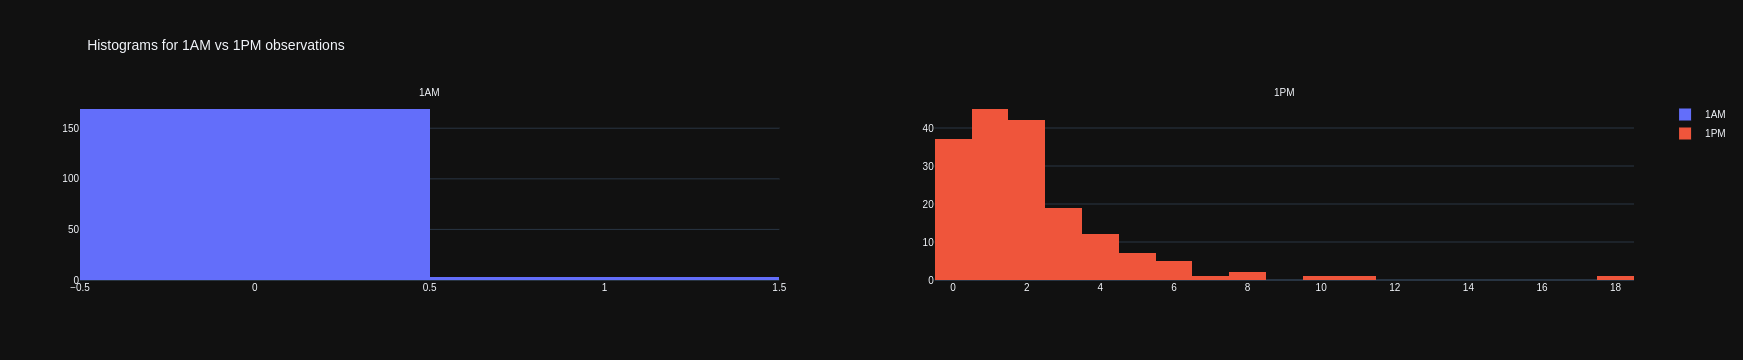

In [266]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('1AM', '1PM'))

fig.add_trace(go.Histogram(x=merged[merged['hour'] == 1]['obs_count'], name='1AM'), row=1, col=1)
fig.add_trace(go.Histogram(x=merged[merged['hour'] == 13]['obs_count'], name='1PM'), row=1, col=2)

fig.update_layout(height=350, width=900, title_text="Histograms for 1AM vs 1PM observations", font=dict(size=10))
for i in fig['layout']['annotations']: i['font'] = dict(size=10)  # change subplot titles size
fig.show()

Then again, it will be different for 7AM week day and 7AM weekend day. It is expected that during the weekend people sleep in more, and during the week they walk the dogs, drive to work etc.

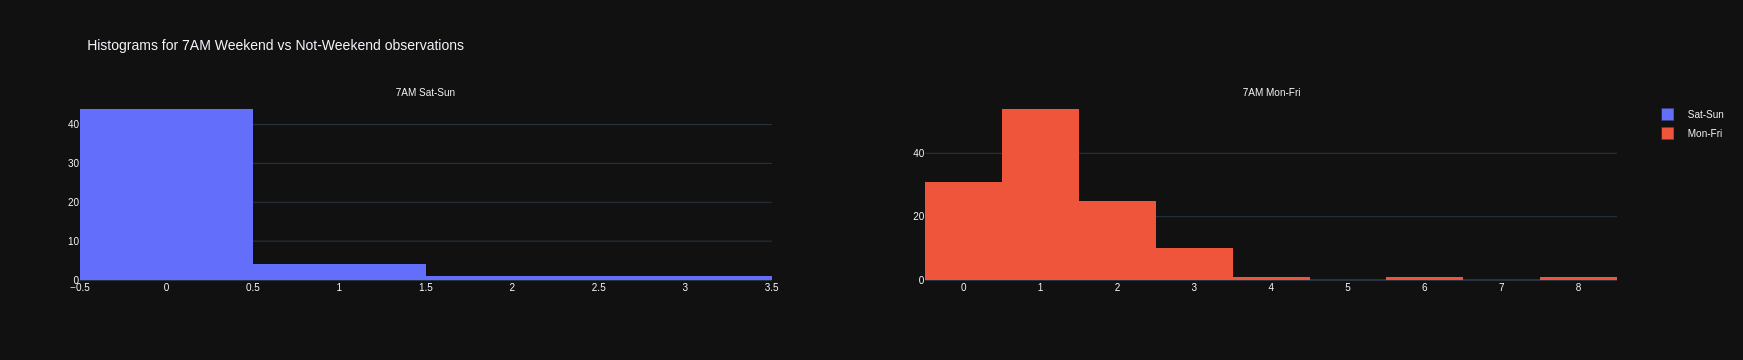

In [270]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('7AM Sat-Sun', '7AM Mon-Fri'))

filtered = merged[merged['hour'] == 7]

fig.add_trace(go.Histogram(x=filtered[filtered['is_weekend_day'] == 1]['obs_count'], name='Sat-Sun'), row=1, col=1)
fig.add_trace(go.Histogram(x=filtered[filtered['is_weekend_day'] == 0]['obs_count'], name='Mon-Fri'), row=1, col=2)

fig.update_layout(height=350, width=900, title_text="Histograms for 7AM Weekend vs Not-Weekend observations", font=dict(size=10))
for i in fig['layout']['annotations']: i['font'] = dict(size=10)  # change subplot titles size
fig.show()

What about the weather impact?

We can see in the plots for 2PM below that if the weather is bad, there is 32% probability of not seeing any object, where it's only 15% when the weather is good.

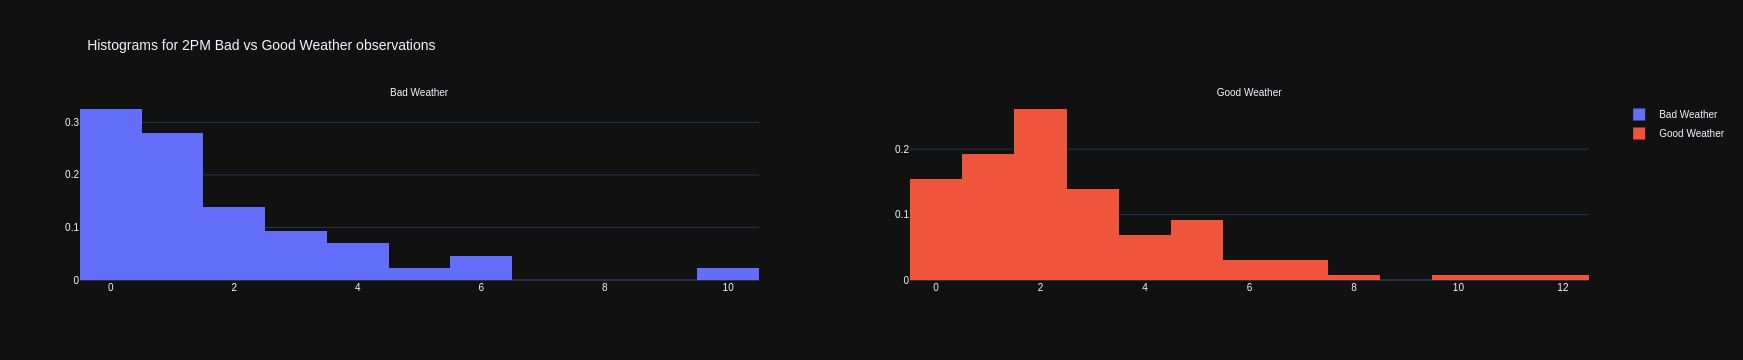

In [276]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Bad Weather', 'Good Weather'))

filtered = merged[merged['hour'] == 14]

bad_weather_words = ['drizzle', 'rain', 'danger']
bad_idx = merged['cur__summary'].str.contains("|".join(bad_weather_words), case=False)

bad_weather = filtered.loc[bad_idx]
good_weather = filtered.loc[~bad_idx]

fig.add_trace(go.Histogram(x=bad_weather['obs_count'], histnorm='probability', name='Bad Weather'), row=1, col=1)
fig.add_trace(go.Histogram(x=good_weather['obs_count'], histnorm='probability', name='Good Weather'), row=1, col=2)

fig.update_layout(height=350, width=900, title_text="Histograms for 2PM Bad vs Good Weather observations", font=dict(size=10))
for i in fig['layout']['annotations']: i['font'] = dict(size=10)  # change subplot titles size
fig.show()

Based on the vizualisations above we can conclude that there is definitely a difference between distributions at different hours of the day.

But what is also interesting is that perhaps, to generate a forecast for the count of observations, additional features can be also utilised and therefore Machine Learning solution could help here.

## Predicting observation counts

It is very useful to generate future predictions for the counts to expect in a full day ahead of time.

Based on this prediction we can inform the user about the situation to expect for the day, and if there is much more objects versus expected counts, we can trigger alerts and potentially prevent an unwanted incident.

My approach to predicting the observation counts for each date and hour is as follows:
- create a simple model without any Machine Learning techniques
- use feature selection techniques to see which features should be included in the ML model
- train a basic Machine Learning model and calculate error rate
- try to incorporate hand-engineered features and see if we can increase the model accuracy
- conclude with the method to use going forward

### Simplest model

If we group the dataset by hour and calculate a mean of object counts - then we can convert that mean to the nearest integer and this is the most basic form of a forecast.

$$forecast(X_h)=roundInt(\frac{1}{n}\sum_{i=1}^{n}x_i)$$

Where $X_h$ is the training dataset containing all observations for a given hour $h$, and $n$ is a number of observations in that training set.

Benefits of this type of a basic forecast:
- easy to understand and explain
- fast to compute, requires low resources
- works for each object class without tweaking

Downsides of this forecast:
- it does not take into account any other factors (like weather type or day of week)
- it's skewed by outliers
- it does not provide the uncertainty about the results

#### Implementation:
- split dataset into training and test stes
- calculate means for each hour
- round means to nearest integer
- calculate errors against the test-set (with cross validation):
    - mean absolute error
    - mean squared error
    - r2 score (coefficient of determination)

Error calculations:

$$meanAbsoluteError=\frac{1}{n}\sum_{i=1}^{n}|true-predicted|$$
$$meanSquaredError=\frac{1}{n}\sum_{i=1}^{n}(true-predicted)^2$$
$$rSquared=1-\frac{SS_{res}}{SS_{tot}}$$

Where $SS_{res}$ is the sum of squares of residuals and $SS_{tot}$ is the total sum of squares [(source)](https://en.wikipedia.org/wiki/Coefficient_of_determination)

Below is a code snippet, which runs a 5-fold cross validation to calculate mean errors across all the folds.

In [280]:
# use features to create the forecast
X = merged[['hour', 'obs_count']]
y = merged['obs_count']

# KFold Cross Validation approach
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Iterate over each train-test split and calculate scores
mses = []
maes = []
r2s = []
for train_index, test_index in tqdm(kf.split(X)):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    # calculate hourly averages of counts for training set
    mean_obj_counts = X_train.groupby('hour')['obs_count'].mean()
    # now we can generate the predictions for the test set
    y_pred = X_test['hour'].map(mean_obj_counts)
    # round results
    y_pred_rounded = np.array([int(round(p)) for p in y_pred])
    # Calculate scores
    mses.append(mean_squared_error(y_test, y_pred_rounded))
    maes.append(mean_absolute_error(y_test, y_pred_rounded))
    r2s.append(r2_score(y_test, y_pred_rounded))
    
print('mean mse:', np.mean(mses))
print('mean mae:', np.mean(maes))
print('mean r2:', np.mean(r2s))


mean mse: 2.8857487922705314
mean mae: 0.9272946859903382
mean r2: 0.24398774282746377


How these errors are distibuted for the last train/test split?

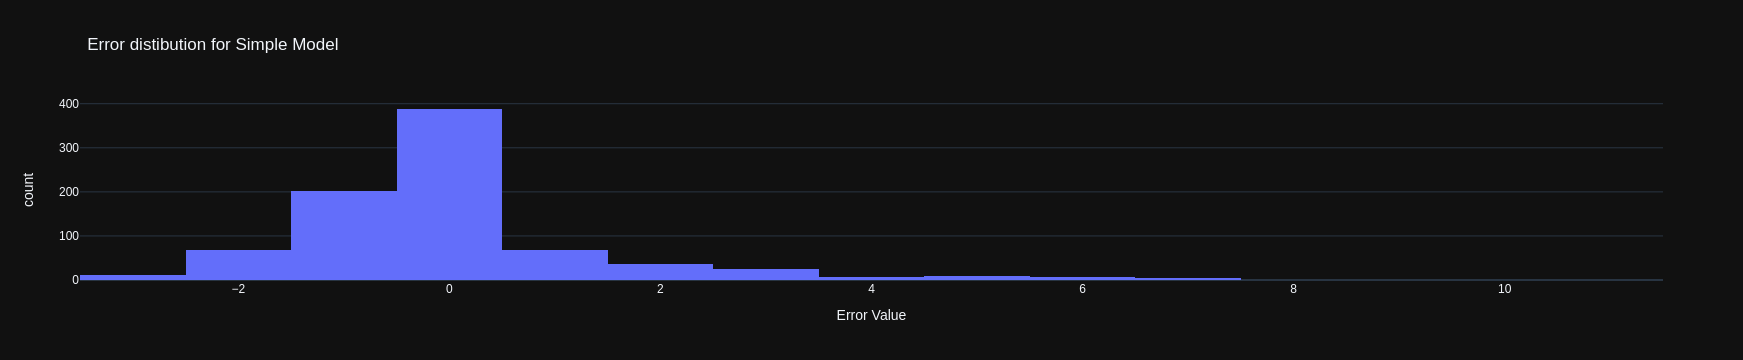

In [291]:
error = y_test - y_pred_rounded
px.histogram(x=error, height=300, width=600, title='Error distibution for Simple Model', labels={'x': 'Error Value'})

#### Conclusion:

The Simple model has perfectly predicted 388 observations out of 828.

Even though the Simple Model generated a somewhat dissapointing statistics, but can be still useful as it allows us to roughly predict how many observations are expected to occur in a given hour.

We can ask this model for an hour and it will give us the prediction:

In [292]:
hour = 16
pred = mean_obj_counts[hour]
print(f'Prediction for hour: {hour} is: {pred}, rounded to: {int(round(pred))} objects expected to see.')

Prediction for hour: 16 is: 2.993006993006993, rounded to: 3 objects expected to see.


### Machine Learning strategy

Predicting object counts is a Supervised Learning, as we do have the historical counts, which can be used as labels.

The predicted values are neither purely discrete or continuous. They are non-negative integers $\{0,1,2,3,4...\}$

I am choosing to investigate a Random Forest Regression model (arguably most powerful model available in sklearn repository of ML models).

I have also attempted other models (like LinearRegression, SVM or even probabilitic models), but none of them have improved the results produced by Random Forest.

#### Note on Neural Networks:

I have not chosen not to use a Neural Network model for forecasting. Neural Networks are more suitable for larger datasets (we have only 4,140 records).

I have tested a standard Feed Forward Neural Network and an Recurrent Neural Network (bidirectional LSTM) sequence prediction model, but they both very quickly overfitted the data and they did not improve the results. They also took much longer to train, they were very sensitive to the parameter choice, and they do not generate the uncertainty about the predictions.

### Feature selection for Machine Learning

Before we apply Machine Learning to the problem, we should first select the features to use. Below are the 3 methods, which I have applied to achieve that:
- select K-Best using statistical test
- feature importances
- correlation matrix

#### K-Best features

Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

TODO: write documentation about how ANOVA works

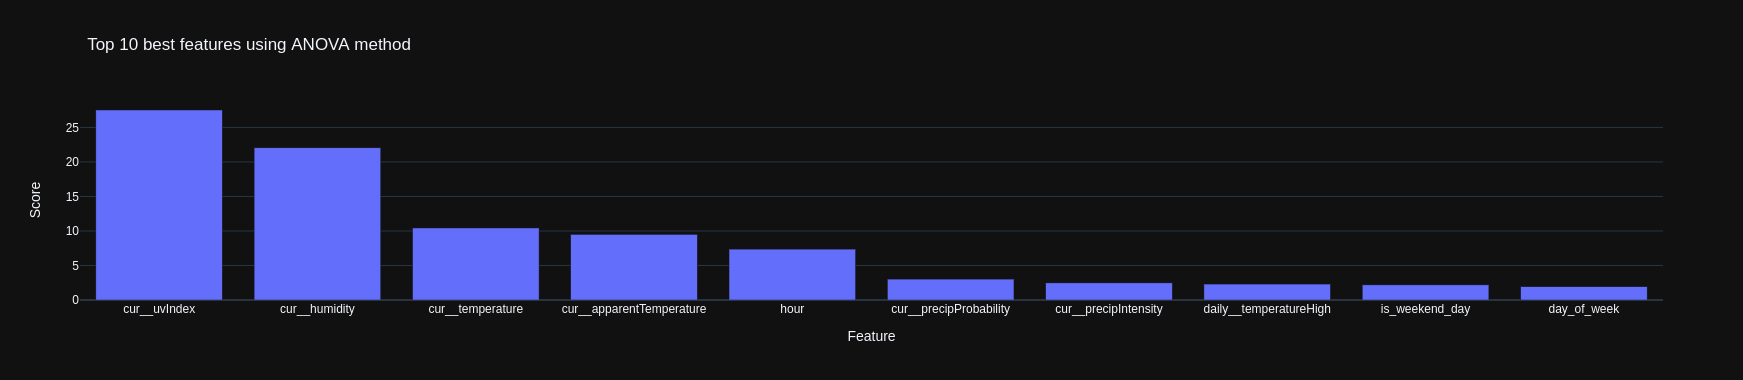

In [293]:
# import necessary libraries
from sklearn.feature_selection import SelectKBest, f_classif

# add a few extra features to the weather features
use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day'] + inspect_cols_flat
X = merged[use_cols]
y = merged['obs_count']

# extract top 10 features
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X, y)

# import features and scores into a dataframe
top10 = pd.DataFrame([dict(zip(X.columns, fit.scores_))]).T.reset_index().sort_values(0, ascending=False).head(10)
top10.columns = ['Feature', 'Score']

# visualize feature scores
px.bar(top10, x='Feature', y='Score', width=600, height=380, title='Top 10 best features using ANOVA method')

#### Feature importance

You can get the feature importance of each feature of your dataset by using the feature importance property of the model.

Feature importance gives you a score for each feature of your data, the higher the score more important or relevant is the feature towards your output variable.

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

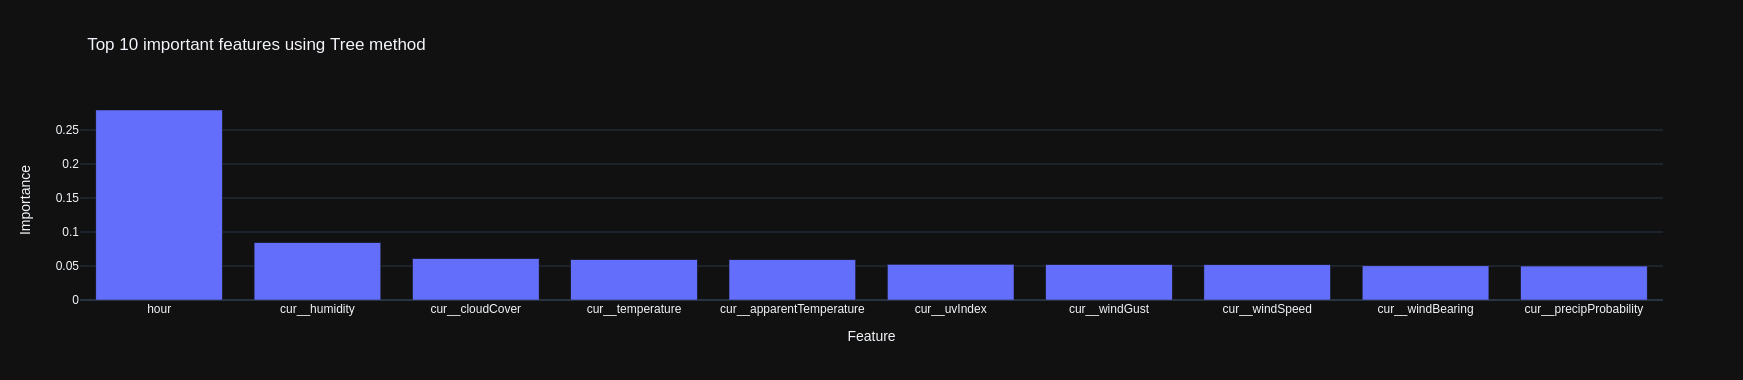

In [294]:
# import necessary libraries
from sklearn.ensemble import ExtraTreesRegressor

# add a few extra features to the weather features
use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day'] + inspect_cols_flat
X = merged[use_cols]
y = merged['obs_count']

# extract feature importances from the Regressor
model = ExtraTreesRegressor()
_ = model.fit(X, y)

# import features and importances into a dataframe
top10 = pd.DataFrame([dict(zip(X.columns, model.feature_importances_))]).T.reset_index().sort_values(0, ascending=False).head(10)
top10.columns = ['Feature', 'Importance']

# visualize feature importances
px.bar(top10, x='Feature', y='Importance', width=600, height=380, title='Top 10 important features using Tree method')

#### Correlation Matrix

Correlation states how the features are related to each other or the target variable.

Correlation can be positive (increase in one value of feature increases the value of the target variable) or negative (increase in one value of feature decreases the value of the target variable). If correlation is near zero, then this feature does not have a direct correlation with the target variable.

Below I will plot the correlations of the features with the `obs_count` target variable.

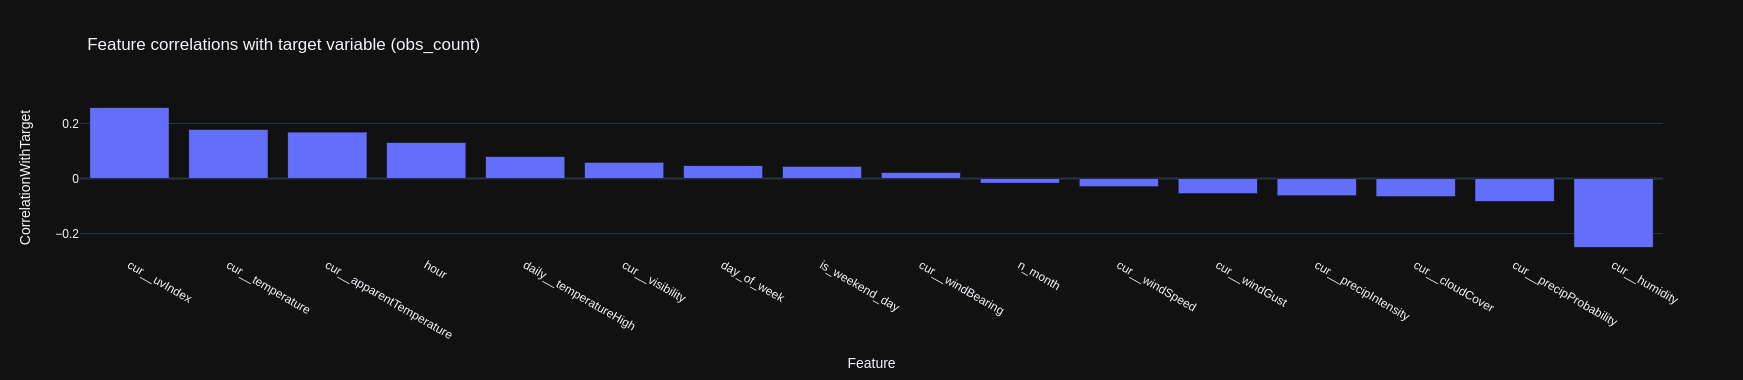

In [295]:
# add a few extra features to the weather features
use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day'] + inspect_cols_flat + ['obs_count']
dataset = merged[use_cols]

# get correlations between features in the dataset
corr_mat = dataset.corr()['obs_count'].reset_index().query('index != "obs_count"')
corr_mat.columns = ['Feature', 'CorrelationWithTarget']

# extract correlations and sort them
corrs = corr_mat.sort_values('CorrelationWithTarget', ascending=False)

# plot correlations with obs_count
px.bar(corrs, x='Feature', y='CorrelationWithTarget', width=800, height=380,
       title='Feature correlations with target variable (obs_count)')

### Train Random Forest Model

#### TODO: Add theory about how Random Forest works

Below is a code snippet, which runs a 5-fold cross validation to calculate mean errors across all the folds.

In [305]:
from sklearn.ensemble import RandomForestRegressor

# add a few extra features to the weather features
use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day'] + inspect_cols_flat
X = merged[use_cols]
y = merged['obs_count']

# KFold Cross Validation approach
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Iterate over each train-test split and calculate scores
mses = []
maes = []
r2s = []
for train_index, test_index in tqdm(kf.split(X)):
    # Split train-test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Scale train and test sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Train model
    model = RandomForestRegressor(n_estimators=300, criterion='mse', n_jobs=6)
    model.fit(X_train_scaled, y_train)
    # Make predictions and round them off
    y_pred = model.predict(X_test_scaled)
    y_pred_rounded = np.array([round(p) for p in y_pred])
    # Calculate scores
    mses.append(mean_squared_error(y_test, y_pred_rounded))
    maes.append(mean_absolute_error(y_test, y_pred_rounded))
    r2s.append(r2_score(y_test, y_pred_rounded))
print('mean mse:', np.mean(mses))
print('mean mae:', np.mean(maes))
print('mean r2:', np.mean(r2s))


mean mse: 2.620048309178744
mean mae: 0.8702898550724637
mean r2: 0.31192552957850816


And now we can take a look at the error distribution:

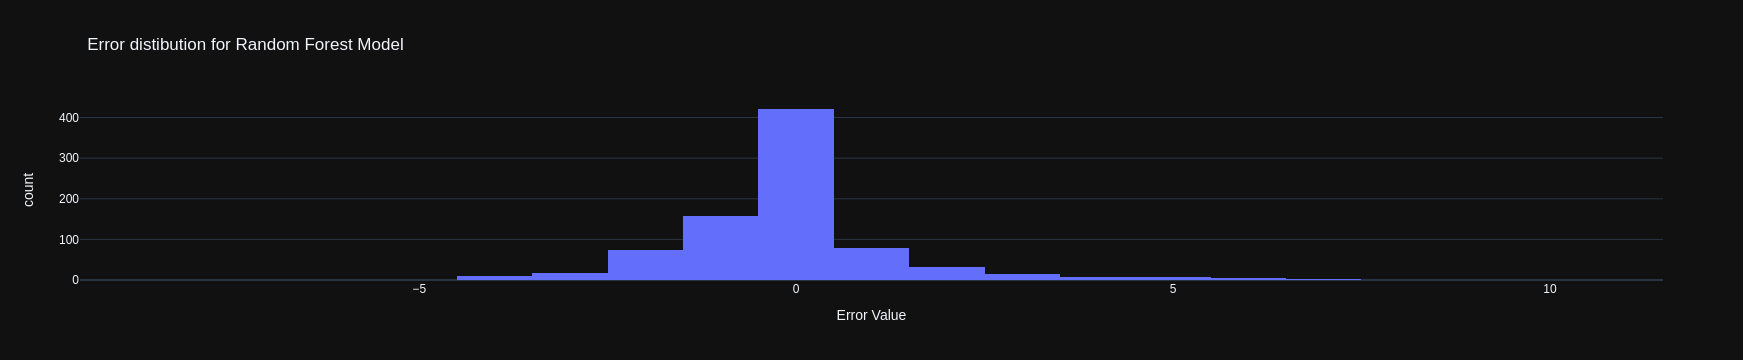

In [302]:
error = y_test - y_pred_rounded
px.histogram(x=error, height=300, width=600, title='Error distibution for Random Forest Model', labels={'x': 'Error Value'})

### Conclusion:

We can observe that using Machine Learning does improve the performance of the model.

It predicted 421 observations perfectly (out of 828).

Looking at the r2 measure, we can see an ~7% improvement against the Simple Averages Model (from ~0.24 to ~0.31).

The errors have been not been reduced dramatically, but it should not be expected from a very stochastic in nature dataset and every improvement in the forecast is good.

### TODO:

Add more theory about the Random Forest model (and maybe try another ML model just for comparison)

Create hand crafted features and see if we can improve the ML model accuracy:
- `is_dark` feature where we use `daily_sunrise` and `daily_sunset` numerical timestamps
- `is_weather_good` feature where we use the `cur__weather_summary` categorical values
- `is_windy` feature where we use the `cur__wind_speed` numerical value
- `is_sat` feature if it's Saturday
- `is_sun` feature if it's a Sunday